<a href="https://colab.research.google.com/github/badineniharshith/Movie-Recommendation-System/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline
sns.set_style('whitegrid')


In [2]:
DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
!wget -q {DATA_URL} -O ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip','r') as z:
    z.extractall()
print("Files:", os.listdir('ml-latest-small')[:10])

movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')
print("movies, ratings, tags shapes:", movies.shape, ratings.shape, tags.shape)
movies.head()


Files: ['movies.csv', 'tags.csv', 'links.csv', 'README.txt', 'ratings.csv']
movies, ratings, tags shapes: (9742, 3) (100836, 4) (3683, 4)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movies['genres_list'] = movies['genres'].apply(lambda s: s.split('|') if isinstance(s, str) else [])
movies['title_clean'] = movies['title'].str.replace(r'\s+\(\d{4}\)$','', regex=True)
movies.head()


,movieId,title,genres,genres_list,title_clean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",Waiting to Exhale
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],Father of the Bride Part II


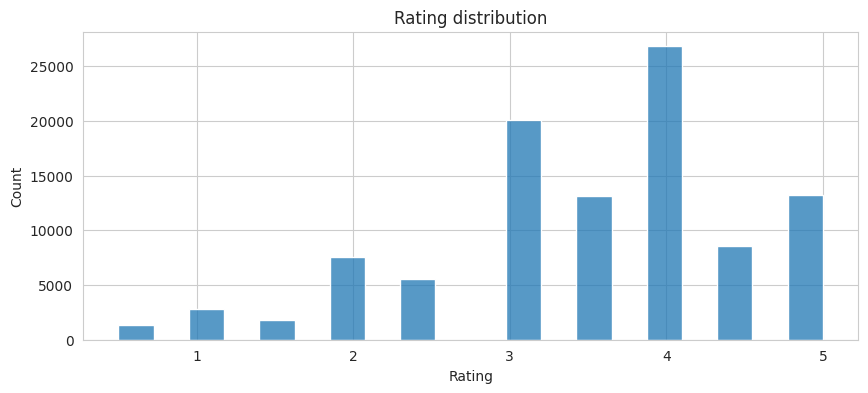

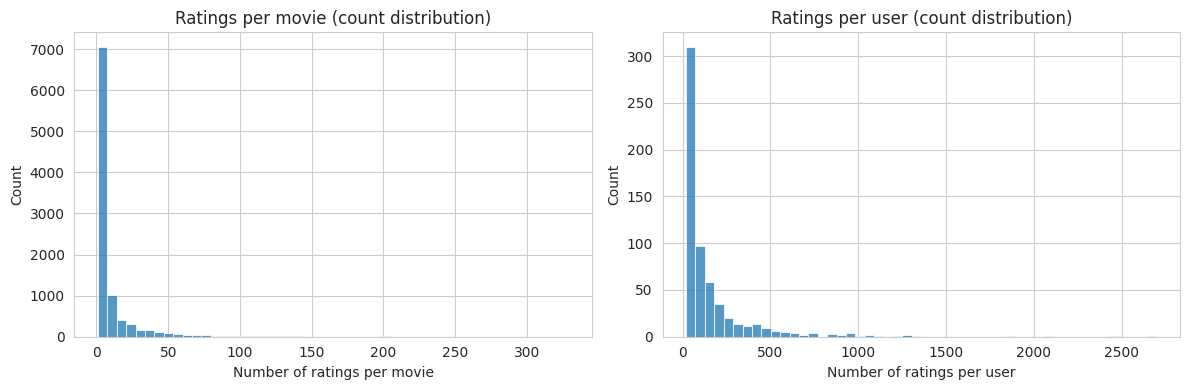

,movieId,rating_mean,rating_count,title_clean
314,356,4.164134,329,Forrest Gump
277,318,4.429022,317,"Shawshank Redemption, The"
257,296,4.197068,307,Pulp Fiction
510,593,4.161290,279,"Silence of the Lambs, The"
1938,2571,4.192446,278,"Matrix, The"
224,260,4.231076,251,Star Wars: Episode IV - A New Hope
418,480,3.750000,238,Jurassic Park
97,110,4.031646,237,Braveheart
507,589,3.970982,224,Terminator 2: Judgment Day
461,527,4.225000,220,Schindler's List


In [4]:
plt.figure(figsize=(10,4))
sns.histplot(ratings['rating'], bins=20)
plt.title('Rating distribution')
plt.xlabel('Rating')
plt.show()

movie_counts = ratings['movieId'].value_counts()
user_counts  = ratings['userId'].value_counts()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(movie_counts, bins=50)
plt.title('Ratings per movie (count distribution)')
plt.xlabel('Number of ratings per movie')

plt.subplot(1,2,2)
sns.histplot(user_counts, bins=50)
plt.title('Ratings per user (count distribution)')
plt.xlabel('Number of ratings per user')
plt.tight_layout()
plt.show()

movie_stats = ratings.groupby('movieId').agg({'rating':['mean','count']})
movie_stats.columns = ['rating_mean','rating_count']
movie_stats = movie_stats.reset_index().merge(movies[['movieId','title_clean']], on='movieId')
movie_stats.sort_values('rating_count', ascending=False).head(10)


In [5]:
top_movies = movie_stats.sort_values('rating_count', ascending=False)

def recommend_popularity(user_id, n=10):
    seen = set(ratings[ratings['userId']==user_id]['movieId'].values)
    recs = top_movies[~top_movies['movieId'].isin(seen)].head(n)
    return recs[['movieId','title_clean','rating_count','rating_mean']]

# Example
print("Popularity recommendations for user 1:")
recommend_popularity(1, n=10)


Popularity recommendations for user 1:


,movieId,title_clean,rating_count,rating_mean
277,318,"Shawshank Redemption, The",317,4.429022
507,589,Terminator 2: Judgment Day,224,3.970982
123,150,Apollo 13,201,3.845771
3633,4993,"Lord of the Rings: The Fellowship of the Ring,...",198,4.106061
659,858,"Godfather, The",192,4.289062
4131,5952,"Lord of the Rings: The Two Towers, The",188,4.021277
4791,7153,"Lord of the Rings: The Return of the King, The",185,4.118919
506,588,Aladdin,183,3.792350
2077,2762,"Sixth Sense, The",179,3.893855
337,380,True Lies,178,3.497191


In [6]:
unique_user_ids = ratings['userId'].unique()
unique_movie_ids = ratings['movieId'].unique()
user_id_to_idx = {uid: i for i, uid in enumerate(unique_user_ids)}
movie_id_to_idx = {mid: i for i, mid in enumerate(unique_movie_ids)}
idx_to_user_id = {i: uid for uid, i in user_id_to_idx.items()}
idx_to_movie_id = {i: mid for mid, i in movie_id_to_idx.items()}

n_users = len(unique_user_ids)
n_movies = len(unique_movie_ids)
print("n_users, n_movies:", n_users, n_movies)

rows = ratings['userId'].map(user_id_to_idx)
cols = ratings['movieId'].map(movie_id_to_idx)
data_vals = ratings['rating'].values
R = csr_matrix((data_vals, (rows, cols)), shape=(n_users, n_movies))
print("User-item sparse matrix shape:", R.shape)


n_users, n_movies: 610 9724
User-item sparse matrix shape: (610, 9724)


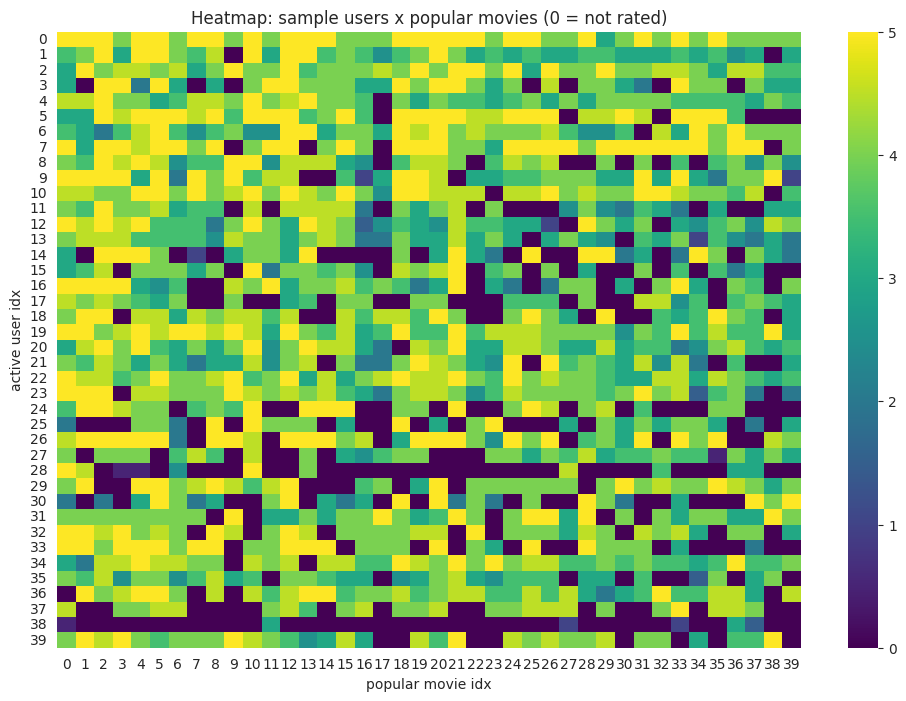

In [7]:
top_user_idxs = user_counts.head(40).index.map(user_id_to_idx).dropna().astype(int).tolist()
top_movie_idxs = movie_stats.sort_values('rating_count', ascending=False).head(40)['movieId'].map(movie_id_to_idx).dropna().astype(int).tolist()

sub = R[top_user_idxs][:, top_movie_idxs].toarray()
plt.figure(figsize=(12,8))
sns.heatmap(sub, cmap='viridis')
plt.title('Heatmap: sample users x popular movies (0 = not rated)')
plt.xlabel('popular movie idx')
plt.ylabel('active user idx')
plt.show()


In [8]:
item_matrix = R.T.toarray()
item_sim = cosine_similarity(item_matrix)
print("Computed item-item similarity matrix:", item_sim.shape)

def item_based_recommend(user_id, top_k=10, n_sim_movies=50):
    if user_id not in user_id_to_idx:
        return pd.DataFrame(columns=['movieId','title_clean','score'])
    uidx = user_id_to_idx[user_id]
    user_ratings_row = R.getrow(uidx).toarray().ravel()
    rated_indices = np.where(user_ratings_row > 0)[0].tolist()
    scores = defaultdict(float)
    sim_sums = defaultdict(float)
    for i in rated_indices:
        r = user_ratings_row[i]
        sims = item_sim[i]
        top_sim_idxs = np.argsort(sims)[-n_sim_movies-1:][::-1]
        for j in top_sim_idxs:
            if j == i:
                continue
            if user_ratings_row[j] > 0:
                continue
            sim = sims[j]
            scores[j] += sim * r
            sim_sums[j] += abs(sim)
    preds = []
    for j in scores:
        if sim_sums[j] > 0:
            preds.append((j, scores[j] / sim_sums[j]))
    preds = sorted(preds, key=lambda x: x[1], reverse=True)[:top_k]
    recs = []
    for midx, score in preds:
        movieId = idx_to_movie_id[midx]
        title = movies.loc[movies['movieId']==movieId, 'title_clean'].values[0]
        recs.append((movieId, title, score))
    return pd.DataFrame(recs, columns=['movieId','title_clean','score'])

print("Item-based recommendations for user 1:")
item_based_recommend(1, top_k=10)


Computed item-item similarity matrix: (9724, 9724)
Item-based recommendations for user 1:


,movieId,title_clean,score
0,2921,High Plains Drifter,5.0
1,6724,Paper Moon,5.0
2,4275,Krull,5.0
3,413,Airheads,5.0
4,48,Pocahontas,5.0
5,1015,Homeward Bound: The Incredible Journey,5.0
6,1947,West Side Story,5.0
7,3730,"Conversation, The",5.0
8,31116,Sergeant York,5.0
9,3334,Key Largo,5.0


In [9]:
R_dense = R.toarray()
user_means = np.true_divide(R_dense.sum(axis=1), (R_dense != 0).sum(axis=1))
user_means = np.nan_to_num(user_means)
R_centered = R_dense.copy()
nonzero_mask = (R_centered != 0)
for i in range(n_users):
    R_centered[i, nonzero_mask[i]] = R_centered[i, nonzero_mask[i]] - user_means[i]

k = 50
print("Running svds with k =", k)
u, s, vt = svds(csr_matrix(R_centered), k=k)
idx = np.argsort(s)[::-1]
s = s[idx]
u = u[:, idx]
vt = vt[idx, :]

Sigma = np.diag(s)
R_centered_pred = np.dot(np.dot(u, Sigma), vt)
R_pred = R_centered_pred + user_means.reshape(-1,1)

R_pred_clipped = np.clip(R_pred, 0.5, 5.0)

print("Matrix factorization done. Predicted matrix shape:", R_pred_clipped.shape)


Running svds with k = 50
Matrix factorization done. Predicted matrix shape: (610, 9724)


In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)

def get_predicted_rating(user_id, movie_id):
    if user_id not in user_id_to_idx or movie_id not in movie_id_to_idx:
        return np.nan
    return R_pred_clipped[user_id_to_idx[user_id], movie_id_to_idx[movie_id]]

y_true = []
y_pred = []
for _, row in test_df.iterrows():
    uid = row['userId']; mid = row['movieId']; true_r = row['rating']
    pred_r = get_predicted_rating(uid, mid)
    if np.isnan(pred_r):
        continue
    y_true.append(true_r)
    y_pred.append(pred_r)

print("Test RMSE (MF):", sqrt(mean_squared_error(y_true, y_pred)))


Test RMSE (MF): 0.622034021879206


In [11]:
def mf_recommend(user_id, n=10):
    if user_id not in user_id_to_idx:
        return pd.DataFrame(columns=['movieId','title_clean','est_rating'])
    uidx = user_id_to_idx[user_id]
    preds = R_pred_clipped[uidx]
    seen = set(ratings[ratings['userId']==user_id]['movieId'].values)
    candidates = [(idx_to_movie_id[i], preds[i]) for i in range(n_movies) if idx_to_movie_id[i] not in seen]
    topn = sorted(candidates, key=lambda x: x[1], reverse=True)[:n]
    dfres = pd.DataFrame(topn, columns=['movieId','est_rating']).merge(movies[['movieId','title_clean']], on='movieId')
    return dfres[['movieId','title_clean','est_rating']]

print("MF recommendations for user 1:")
mf_recommend(1, n=10)


MF recommendations for user 1:


,movieId,title_clean,est_rating
0,541,Blade Runner,4.713017
1,344,Ace Ventura: Pet Detective,4.677371
2,5952,"Lord of the Rings: The Two Towers, The",4.659489
3,2804,"Christmas Story, A",4.656518
4,4993,"Lord of the Rings: The Fellowship of the Ring,...",4.620962
5,7153,"Lord of the Rings: The Return of the King, The",4.619534
6,1246,Dead Poets Society,4.588611
7,4011,Snatch,4.588176
8,858,"Godfather, The",4.587285
9,2300,"Producers, The",4.581863


In [12]:
from collections import defaultdict
import numpy as np

def build_test_gt(testset_df, threshold=4.0):
    gt = defaultdict(set)
    for _, row in testset_df.iterrows():
        if row['rating'] >= threshold:
            gt[row['userId']].add(row['movieId'])
    return gt

gt = build_test_gt(test_df, threshold=4.0)

def call_recommender_with_k(recommender_fn, uid, k):

    try_calls = [
        (lambda: recommender_fn(uid, n=k)),
        (lambda: recommender_fn(uid, top_k=k)),
        (lambda: recommender_fn(uid, k)),
        (lambda: recommender_fn(uid, top_k=k, n_sim_movies=50)),
        (lambda: recommender_fn(uid, n=k, top_k=k))
    ]
    for call in try_calls:
        try:
            res = call()
            return res
        except TypeError:
            continue
    try:
        return recommender_fn(uid)
    except Exception as e:
        raise e

def precision_recall_at_k(recommender_fn, gt, k=10):
    precisions = []
    recalls = []
    for uid, true_set in gt.items():
        if len(true_set) == 0:
            continue
        try:
            recs = call_recommender_with_k(recommender_fn, uid, k)
        except Exception as e:

            continue

        if recs is None:
            rec_ids = []
        else:
            if isinstance(recs, list):
                if len(recs) == 0:
                    rec_ids = []
                else:
                    first = recs[0]
                    if isinstance(first, tuple) or isinstance(first, list):
                        rec_ids = [int(x[0]) for x in recs]
                    else:
                        rec_ids = [int(x) for x in recs]
            else:
                try:
                    rec_ids = recs['movieId'].astype(int).tolist() if not recs.empty else []
                except Exception:
                    try:
                        rec_ids = list(map(int, list(recs)))
                    except Exception:
                        rec_ids = []

        hit_count = len(set(rec_ids) & set(true_set))
        precisions.append(hit_count / k)
        recalls.append(hit_count / len(true_set))
    if len(precisions) == 0:
        return np.nan, np.nan
    return np.mean(precisions), np.mean(recalls)

print("Evaluating top-10:")
p_mf, r_mf = precision_recall_at_k(mf_recommend, gt, k=10)
p_item, r_item = precision_recall_at_k(item_based_recommend, gt, k=10)
p_pop, r_pop = precision_recall_at_k(recommend_popularity, gt, k=10)

print(f"MF Precision@10: {p_mf:.4f}, Recall@10: {r_mf:.4f}")
print(f"Item-CF Precision@10: {p_item:.4f}, Recall@10: {r_item:.4f}")
print(f"Popularity Precision@10: {p_pop:.4f}, Recall@10: {r_pop:.4f}")


Evaluating top-10:
MF Precision@10: 0.0000, Recall@10: 0.0000
Item-CF Precision@10: 0.0000, Recall@10: 0.0000
Popularity Precision@10: 0.0000, Recall@10: 0.0000


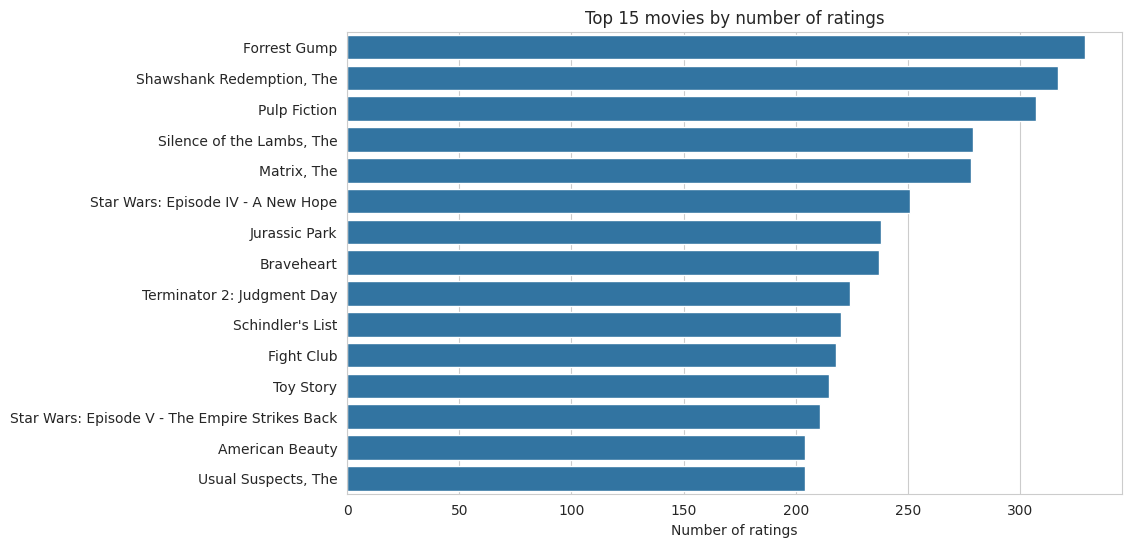

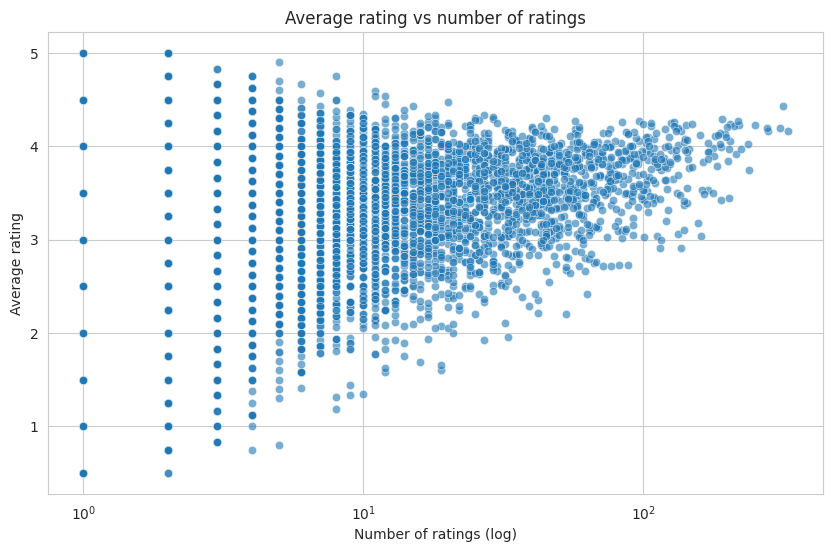

In [13]:
top_popular = movie_stats.sort_values('rating_count', ascending=False).head(15)
plt.figure(figsize=(10,6))
sns.barplot(y='title_clean', x='rating_count', data=top_popular)
plt.title('Top 15 movies by number of ratings')
plt.xlabel('Number of ratings')
plt.ylabel('')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(data=movie_stats, x='rating_count', y='rating_mean', alpha=0.6)
plt.xscale('log')
plt.xlabel('Number of ratings (log)')
plt.ylabel('Average rating')
plt.title('Average rating vs number of ratings')
plt.show()


movie_factors shape: (9724, 50)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


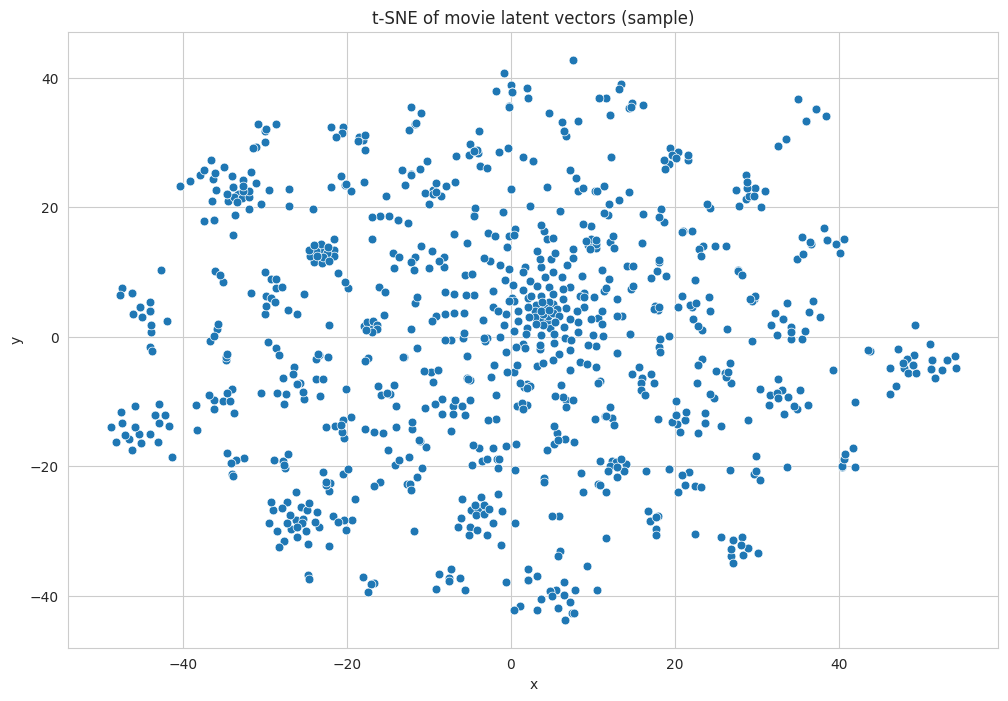

In [14]:
movie_factors = vt.T
print("movie_factors shape:", movie_factors.shape)

sample_idx = np.random.choice(range(n_movies), size=min(1000, n_movies), replace=False)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=800)
emb = tsne.fit_transform(movie_factors[sample_idx])

emb_df = pd.DataFrame(emb, columns=['x','y'])
emb_df['movieId'] = [idx_to_movie_id[i] for i in sample_idx]
emb_df = emb_df.merge(movies[['movieId','title_clean']], on='movieId')

plt.figure(figsize=(12,8))
sns.scatterplot(data=emb_df, x='x', y='y', s=40)
plt.title('t-SNE of movie latent vectors (sample)')
plt.show()


In [15]:
import joblib
joblib.dump(R_pred_clipped, 'mf_pred_matrix.joblib')
joblib.dump(item_sim, 'item_similarity_matrix.joblib')
print("Saved mf_pred_matrix.joblib and item_similarity_matrix.joblib")


Saved mf_pred_matrix.joblib and item_similarity_matrix.joblib


testing

In [16]:
user_id = 10

print("Movies user has already seen:")
display(ratings[ratings['userId'] == user_id].merge(movies[['movieId','title_clean']], on='movieId').head(10))

print("\n Popularity Recommendations:")
display(recommend_popularity(user_id, n=10))

print("\n Item-based CF Recommendations:")
display(item_based_recommend(user_id, top_k=10))

print("\n Matrix Factorization Recommendations:")
display(mf_recommend(user_id, n=10))


Movies user has already seen:


,userId,movieId,rating,timestamp,title_clean
0,10,296,1.0,1455303387,Pulp Fiction
1,10,356,3.5,1455301685,Forrest Gump
2,10,588,4.0,1455306173,Aladdin
3,10,597,3.5,1455357645,Pretty Woman
4,10,912,4.0,1455302254,Casablanca
5,10,1028,0.5,1455306152,Mary Poppins
6,10,1088,3.0,1455619275,Dirty Dancing
7,10,1247,3.0,1455303518,"Graduate, The"
8,10,1307,3.0,1455357613,When Harry Met Sally...
9,10,1784,3.5,1455301699,As Good as It Gets



 Popularity Recommendations:


,movieId,title_clean,rating_count,rating_mean
277,318,"Shawshank Redemption, The",317,4.429022
510,593,"Silence of the Lambs, The",279,4.161290
224,260,Star Wars: Episode IV - A New Hope,251,4.231076
418,480,Jurassic Park,238,3.750000
97,110,Braveheart,237,4.031646
507,589,Terminator 2: Judgment Day,224,3.970982
461,527,Schindler's List,220,4.225000
0,1,Toy Story,215,3.920930
897,1196,Star Wars: Episode V - The Empire Strikes Back,211,4.215640
46,50,"Usual Suspects, The",204,4.237745



 Item-based CF Recommendations:


,movieId,title_clean,score
0,33162,Kingdom of Heaven,5.0
1,5521,"Principal, The",5.0
2,87485,Bad Teacher,5.0
3,160271,Central Intelligence,5.0
4,40278,Jarhead,5.0
5,43871,Firewall,5.0
6,37386,Aeon Flux,5.0
7,46965,Snakes on a Plane,5.0
8,4776,Training Day,5.0
9,6383,"2 Fast 2 Furious (Fast and the Furious 2, The)",5.0



 Matrix Factorization Recommendations:


,movieId,title_clean,est_rating
0,150,Apollo 13,3.577530
1,6539,Pirates of the Caribbean: The Curse of the Bla...,3.566909
2,5816,Harry Potter and the Chamber of Secrets,3.562809
3,5299,My Big Fat Greek Wedding,3.534162
4,1250,"Bridge on the River Kwai, The",3.532863
5,919,"Wizard of Oz, The",3.528828
6,10,GoldenEye,3.516869
7,1499,Anaconda,3.506343
8,1207,To Kill a Mockingbird,3.503822
9,48,Pocahontas,3.490056


In [17]:
uid = 10
mid = 50

pred_rating = get_predicted_rating(uid, mid)
print("Predicted rating:", pred_rating)


Predicted rating: 2.906514220198554


In [18]:
rmse_value = sqrt(mean_squared_error(y_true, y_pred))
print("Matrix Factorization RMSE:", rmse_value)


Matrix Factorization RMSE: 0.622034021879206


In [19]:
m1 = 1
m2 = 31

i1 = movie_id_to_idx[m1]
i2 = movie_id_to_idx[m2]

print("Similarity score:", item_sim[i1, i2])


Similarity score: 0.1783823052850187


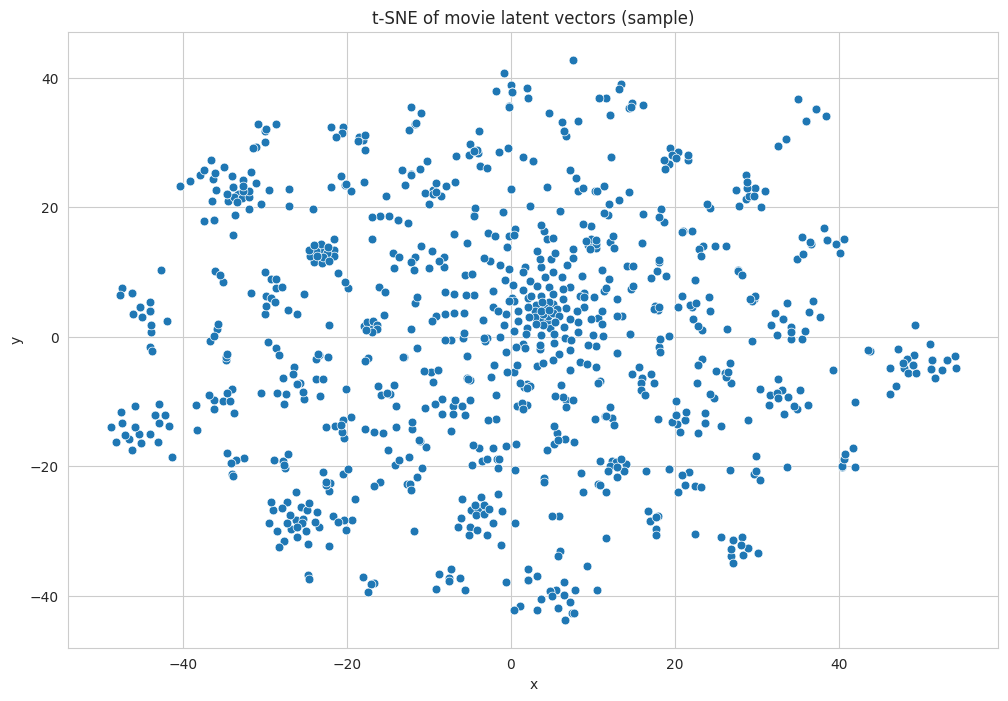

In [20]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=emb_df, x='x', y='y', s=40)
plt.title('t-SNE of movie latent vectors (sample)')
plt.show()
